# Задание
<p><span lang="ru-RU"><i><b>Регрессионная задача</b></i></span><span lang="ru-RU">. Изначально требуется провести анализ всех имеющихся признаков (</span><span lang="ru-RU"><i>признаки, начинающиеся на: </i></span><i><b>NUM</b></i><span lang="ru-RU"><i> - вещественные; </i></span><i><b>CAT</b></i><span lang="ru-RU"><i> - категориальные/бинарные</i></span><span lang="ru-RU">) и выборки в целом. Процесс анализа полностью по пунктам описать. После обработки данных требуется обучить </span>ML<span lang="ru-RU"> модель на обучающей выборке (см. поле &ldquo;Разбивка&rdquo; в файле) и предсказать целевую по данным тестовой выборки (см. поле &ldquo;Разбивка&rdquo;), целевая &mdash; </span><b>TARGET</b><span lang="ru-RU">. Данные полностью обезличены, так что придется ориентироваться только на статистики и связь с целевой. Особое внимание требуется уделить категориальным данным и их анализу с подробным описанием. Выборка заранее разбита нами на обучение и тест (см. поле &ldquo;Разбивка&rdquo;)</span></p>
<p><span lang="ru-RU"> </span><span lang="ru-RU"><i><b>Метрики качества</b></i></span><span lang="ru-RU">: </span>MAPE<span lang="ru-RU">, собственная метрика.</span></p>
<p><span lang="ru-RU"> </span><span lang="ru-RU"><i><b>Собственная</b></i></span><i><b> </b></i><span lang="ru-RU"><i><b>метрика</b></i></span><i><b>:</b></i> <span lang="ru-RU">до</span> 80 = <span lang="ru-RU">ДОЛЯ</span>(<b>TARGET/PREDICT &lt; 0,8</b>); <span lang="ru-RU">более</span> 120 = <span lang="ru-RU">ДОЛЯ</span>(<b>TARGET/PREDICT &gt; 1,2</b>); 80-120 = <span lang="ru-RU">ДОЛЯ</span>((<b>TARGET/PREDICT &gt;= 0,8)&amp;&amp;(TARGET/PREDICT &lt;= 1,2)</b>). <span lang="ru-RU">Повышением качества модели является максимизация доли &laquo;80-120&raquo;, минимизация доли &laquo;до 80&raquo; и минимизация </span>MAPE<span lang="ru-RU">.</span></p>

# Подключение библиотек и файловых данных

- https://gist.github.com/nalgeon/5307af065ff0e3bc97927c832fabe26b - данные по городам: регион и координаты
- https://mydata.biz/ru/catalog/databases/borders_ru - карта, административно-территориальные границы РФ

In [1]:
# для отображения карты
!pip install geopandas
!pip install Shapely

     |████████████████████████████████| 994 kB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 43.6 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 


In [2]:
!pip uninstall scikit-learn -y
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scipy-wheels-nightly/simple
     |████████████████████████████████| 22.7 MB 1.4 MB/s 


In [3]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 28 kB/s 


In [43]:
# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from joblib import dump

# geo data
import geopandas as gpd
from shapely.geometry import Point, Polygon

# stats
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

# transform data
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

# models
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn import svm

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

# metris
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score, make_scorer

In [5]:
df = pd.read_excel('data/data.xlsx')

# Данные регионов и коордиант
city_coords = pd.read_csv('data/tableconvert_csv_uladfy.csv', sep=',')

# Карта границ субъектов РФ
gdf = gpd.read_file('data/admin_level_4.shp')

# 1 Осмотр данных

In [6]:
print('Размер датасета:', df.shape)

Размер датасета: (2055, 32)


In [7]:
df.head()

,ID,CITY,NUM_1,NUM_2,NUM_3,NUM_4,NUM_5,CAT_1,CAT_2,CAT_3,CAT_4,CAT_5,NUM_6,CAT_7,NUM_7,NUM_8,CAT_8,NUM_9,CAT_9,CAT_10,NUM_10,NUM_11,NUM_12,CAT_11,CAT_12,CAT_13,CAT_14,CAT_15,CAT_16,CAT_17,TARGET,Разбивка
0,1,Камышин,0.235583,0.303522,0.445840,0.500000,0.021977,0,0,0,0,0,0.349891,0,0.000000,0.000000,1,0.048239,0,0,0.752511,0.790898,0.275362,1,0,0,0,0,0,1,0.647650,Обучение
1,2,Астрахань,0.372025,0.254108,0.000000,0.877551,0.008615,2,0,0,0,1,0.000000,1,0.137931,0.000000,0,0.401651,0,0,0.805380,0.813467,0.369565,0,0,0,0,0,1,1,0.812763,Обучение
2,3,Волгоград,0.270541,0.463390,0.175540,0.785714,0.002930,1,0,0,0,0,0.090554,0,0.224138,0.000000,1,0.801169,0,1,0.000000,0.850329,0.434783,0,0,0,0,0,0,0,0.445332,Обучение
3,4,Волгоград,0.350128,0.248393,0.161764,0.765306,0.013337,1,0,0,0,0,0.154775,1,0.086207,0.083333,1,0.801169,0,0,0.822238,0.812009,0.434783,0,0,0,0,0,0,1,0.601920,Обучение
4,5,Волгоград,0.215887,0.183692,0.114885,0.897959,0.000000,0,0,0,0,0,0.147988,0,0.000000,0.166667,0,0.801169,0,0,0.751281,0.760845,0.434783,0,0,0,0,0,0,0,0.242790,Обучение


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        2055 non-null   int64  
 1   CITY      2055 non-null   object 
 2   NUM_1     2055 non-null   float64
 3   NUM_2     2055 non-null   float64
 4   NUM_3     2055 non-null   float64
 5   NUM_4     2055 non-null   float64
 6   NUM_5     2055 non-null   float64
 7   CAT_1     2055 non-null   int64  
 8   CAT_2     2055 non-null   int64  
 9   CAT_3     2055 non-null   int64  
 10  CAT_4     2055 non-null   int64  
 11  CAT_5     2055 non-null   int64  
 12  NUM_6     2055 non-null   float64
 13  CAT_7     2055 non-null   int64  
 14  NUM_7     2055 non-null   float64
 15  NUM_8     2055 non-null   float64
 16  CAT_8     2055 non-null   int64  
 17  NUM_9     2055 non-null   float64
 18  CAT_9     2055 non-null   int64  
 19  CAT_10    2055 non-null   int64  
 20  NUM_10    2055 non-null   floa

In [9]:
df.describe()

,ID,NUM_1,NUM_2,NUM_3,NUM_4,NUM_5,CAT_1,CAT_2,CAT_3,CAT_4,CAT_5,NUM_6,CAT_7,NUM_7,NUM_8,CAT_8,NUM_9,CAT_9,CAT_10,NUM_10,NUM_11,NUM_12,CAT_11,CAT_12,CAT_13,CAT_14,CAT_15,CAT_16,CAT_17,TARGET
count,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.00000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000
mean,1028.000000,0.245829,0.188817,0.055477,0.817419,0.020071,0.574209,0.040876,0.108029,0.040876,0.069586,0.091565,0.257421,0.048989,0.100081,0.66326,0.422718,0.265207,0.080292,0.666697,0.734700,0.370525,0.060827,0.028710,0.030170,0.008273,0.106083,0.012165,0.904136,0.203584
std,593.371722,0.112399,0.108022,0.118752,0.167317,0.038889,0.884914,0.198051,0.310493,0.207651,0.256416,0.209212,0.437320,0.100917,0.148312,0.47271,0.317542,0.441551,0.271811,0.270301,0.144664,0.158826,0.239071,0.167032,0.171097,0.090598,0.308018,0.109651,0.294476,0.120550
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,514.500000,0.160573,0.112601,0.000000,0.775510,0.002624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.151689,0.000000,0.000000,0.630704,0.684888,0.268116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.117326
50%,1028.000000,0.240204,0.169670,0.001448,0.867347,0.009004,0.000000,0.000000,0.000000,0.000000,0.000000,0.001930,0.000000,0.000000,0.000000,1.00000,0.383905,0.000000,0.000000,0.753172,0.761851,0.362319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.183051
75%,1541.500000,0.315726,0.244415,0.050720,0.928571,0.022330,1.000000,0.000000,0.000000,0.000000,0.000000,0.070063,1.000000,0.051724,0.166667,1.00000,0.658139,1.000000,0.000000,0.835882,0.821373,0.456522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.261853
max,2055.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1 Вывод
- `ID` - идентификатор записи, вероятно неинформативный признак
- `Разбивка` - признак для разбиения данных на обучающую и тестовую выборки
- `CITY` - возможно категориальный признак
- Все признаки `NUM_` (вещественные) и `CAT_` (категориальные) вероятно информативные и подойдут для обучения модели
- К категориальным признакам надо применить One-hot-encoding, а к вещественным - метод главных компонент для снижения размерности
- Все вещественные признаки лежат в диапазоне [0;1]. Применять к ним масштабирование не надо.
- Пропусков нет

# 2 Анализ данных

Разделим категориальные и вещественные признаки

In [10]:
num_features = [col for col in df.columns if 'NUM' in col]
print('Вещественные признаки:', num_features)

cat_features = [col for col in df.columns if 'CAT' in col]
print('Категориальные признаки:', cat_features)

Вещественные признаки: ['NUM_1', 'NUM_2', 'NUM_3', 'NUM_4', 'NUM_5', 'NUM_6', 'NUM_7', 'NUM_8', 'NUM_9', 'NUM_10', 'NUM_11', 'NUM_12']
Категориальные признаки: ['CAT_1', 'CAT_2', 'CAT_3', 'CAT_4', 'CAT_5', 'CAT_7', 'CAT_8', 'CAT_9', 'CAT_10', 'CAT_11', 'CAT_12', 'CAT_13', 'CAT_14', 'CAT_15', 'CAT_16', 'CAT_17']


## 2.1. Целевой признак

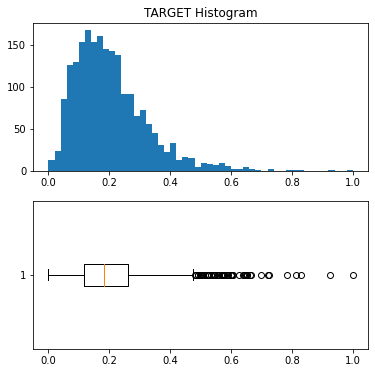

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1)

fig.set_figwidth(6)
fig.set_figheight(6)

_ = ax1.hist(df['TARGET'], bins=50)
ax1.set(title='TARGET Histogram')

#ax2.set(title='TARGET Boxplot')
_ = ax2.boxplot(df['TARGET'], vert=False)

plt.show()

In [12]:
print(df['TARGET'].describe())

count    2055.000000
mean        0.203584
std         0.120550
min         0.000000
25%         0.117326
50%         0.183051
75%         0.261853
max         1.000000
Name: TARGET, dtype: float64


Большинство значений в интервале между 0.11 и 0.26 

## 2.2. Категориальные данные

Взглянем как распределён баланс признаков (bar) и как распределен целевой признак для каждого значения каждой категории (boxplot)

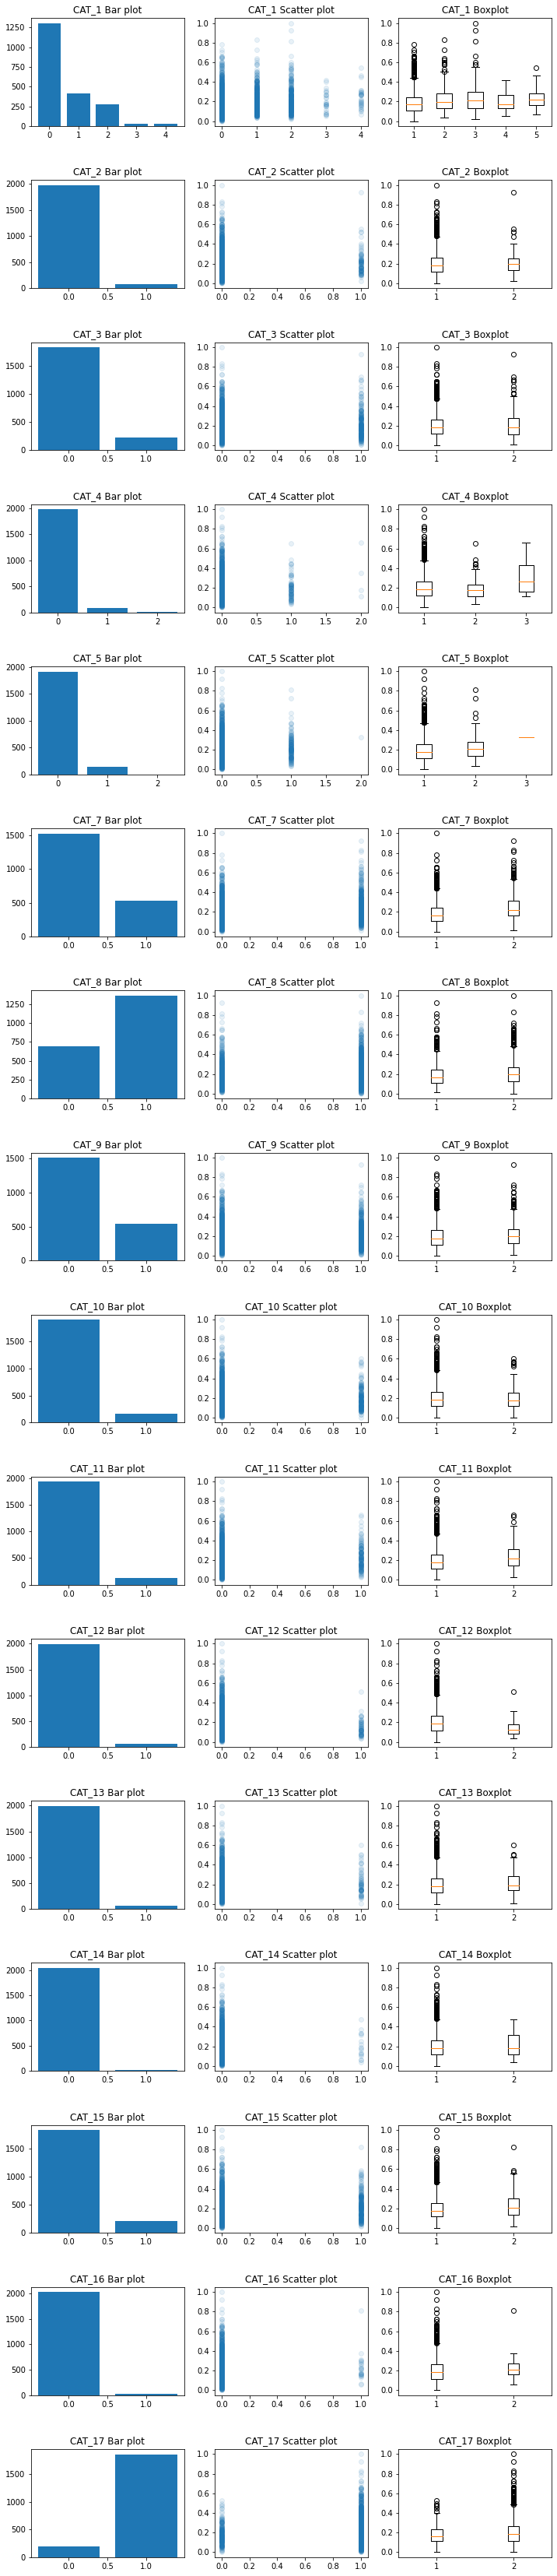

In [13]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
axs = [0 for i in range(len(cat_features))]
fig, axs = plt.subplots(len(axs), 3)

fig.set_figwidth(12)
fig.set_figheight(60)

plt.subplots_adjust(hspace=.5)

for i, cat_name in enumerate(cat_features):
  df_cat = df[cat_name].value_counts().sort_index()

  axs[i][0].set(title=cat_name+' Bar plot')
  _ = axs[i][0].bar(df_cat.index, df_cat)

  axs[i][1].set(title=cat_name+' Scatter plot')
  _ = axs[i][1].scatter(df[cat_name], df['TARGET'], alpha=.1)

  axs[i][2].set(title=cat_name+' Boxplot')
  boxplots = [df[df[cat_name] == cat_val]['TARGET'].values for cat_val in df_cat.index]
  _ = axs[i][2].boxplot(boxplots)


plt.show()

- Во многих категориальных признаках присутствует дисбаланс.
- В классах, которые преобладают по количеству, также присутствует больший разброс значений целевого признака

## 2.3 Города

Попробуем распределить города по регионам

### Регионы

Посмотрим на уникальные значения городов

In [14]:
city_counts = df['CITY'].value_counts()
city_df = city_counts.index 
city_counts

Казань        95
Самара        88
Саратов       87
Волгоград     82
Челябинск     82
              ..
Георгиевск     5
Троицк         4
Елабуга        4
Бузулук        3
Элиста         3
Name: CITY, Length: 82, dtype: int64

Посмотрим на скачанный файл 

In [15]:
city_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Индекс                             1108 non-null   float64
 1   Тип региона                        1112 non-null   object 
 2   Регион                             1112 non-null   object 
 3   Тип района                         629 non-null    object 
 4   Район                              629 non-null    object 
 5   Тип города                         1108 non-null   object 
 6   Город                              1108 non-null   object 
 7   Тип н/п                            2 non-null      object 
 8   Н/п                                2 non-null      object 
 9   Код КЛАДР                          1112 non-null   int64  
 10  Код ФИАС                           1112 non-null   object 
 11  Уровень по ФИАС                    1112 non-null   objec

В столбцах `Регион`, `Широта` и `Долгота` пропусков нет

In [16]:
city_coords.head(3)

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,Код ФИАС,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
0,385200.0,Респ,Адыгея,NaN,NaN,г,Адыгейск,NaN,NaN,100000200000,ccdfd496-8108-4655-aadd-bd228747306d,4: город,0,79403000000,7.970300e+10,107,UTC+3,44.878372,39.190172,Южный,12689
1,385000.0,Респ,Адыгея,NaN,NaN,г,Майкоп,NaN,NaN,100000100000,8cfbe842-e803-49ca-9347-1ef90481dd98,4: город,2,79401000000,7.970100e+10,105,UTC+3,44.609827,40.100653,Южный,144055
2,649000.0,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,NaN,NaN,400000100000,0839d751-b940-4d3d-afb6-5df03fdd7791,4: город,2,84401000000,8.470100e+07,400,UTC+7,51.958268,85.960296,Сибирский,62861


In [17]:
missed_regions = [] # сохраним  пропущенные регионы, если такие есть
multi_regions = []  # сохраним  города с несколькими регионами, если такие есть
def getRegionCode(city):
  try:
    city_df = city_coords[city_coords['Город'] == city]
    if city_df.shape[0] > 1 and city not in multi_regions:
      multi_regions.append(city)
    return city_df['Регион'].values[0]
  except:
    if city not in missed_regions:
      missed_regions.append(city)
    return ''

missed_coords = [] # сохраним  пропущенные координаты, если такие есть
def getCoordinates(city):
  try:
    city_df = city_coords[city_coords['Город'] == city]
    return city_df['Широта'].values[0], city_df['Долгота'].values[0]
  except:
    if city not in missed_coords:
      missed_coords.append(city)
    return '', ''

df['REGION'] = df['CITY'].apply(getRegionCode)
df['LAT'], df['LNG'] = zip(*df['CITY'].apply(getCoordinates))

In [18]:
print('Отсутствующие значения регионов:', missed_regions)
print('Несколько значений регионов:', multi_regions)
print('Отсутствующие значения коордиант:', missed_coords)

Отсутствующие значения регионов: []
Несколько значений регионов: ['Михайловск', 'Заречный', 'Киров']
Отсутствующие значения коордиант: []


Посмотрим на города с одинаковыми названиями

In [19]:
city_multi_regions = city_coords[city_coords['Город'].isin(multi_regions)]
city_multi_regions['Население'] = city_multi_regions['Население'].astype('int')
city_multi_regions.sort_values('Население')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,Код ФИАС,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
842,623080.0,обл,Свердловская,р-н,Нижнесергинский,г,Михайловск,NaN,NaN,6601700200000,177c10d7-f36f-449e-a94b-5f7f45a0dbc8,4: город,0,65228504000,6.562810e+07,6619,UTC+5,56.436974,59.113865,Уральский,9215
829,624250.0,обл,Свердловская,NaN,NaN,г,Заречный,NaN,NaN,6600000500000,8018ae42-55a5-4297-a126-b482aee0b634,4: город,0,65426000000,6.573700e+07,6683,UTC+5,56.810334,61.338059,Уральский,26803
275,249440.0,обл,Калужская,р-н,Кировский,г,Киров,NaN,NaN,4001100100000,7c875ac0-5c75-4798-8786-564ccb5bd9f2,4: город,1,29214501000,2.961410e+10,4023,UTC+3,54.079082,34.307751,Центральный,31888
676,442960.0,обл,Пензенская,NaN,NaN,г,Заречный,NaN,NaN,5800000200000,ff38fc0c-d739-4627-a2f4-58af8f3d9d42,4: город,0,56534000000,5.673400e+07,5838,UTC+3,53.196101,45.169150,Приволжский,63579
896,356240.0,край,Ставропольский,р-н,Шпаковский,г,Михайловск,NaN,NaN,2602700100000,51007e5c-e430-4f18-912c-f88c7e73698d,4: город,1,7258501000,7.658101e+06,2600,UTC+3,45.129630,42.028787,Северо-Кавказский,71018
333,610000.0,обл,Кировская,NaN,NaN,г,Киров,NaN,NaN,4300000100000,452a2ddf-88a1-4e35-8d8d-8635493768d4,4: город,2,33401000000,3.370100e+10,4345,UTC+3,58.603531,49.667922,Приволжский,473668


В идеале: надо уточнить к каким регионам относятся города, возможно к тем, что с большим населением. Но если таких немного,то в данный момент можно удалить

In [20]:
df_multi = df[df['CITY'].isin(multi_regions)]
print('Размер удаляемых', df_multi.shape)
print('Доля удаляемых:', int(df_multi.shape[0]/df.shape[0]*100), '%')
df_multi.head()

Размер удаляемых (74, 35)
Доля удаляемых: 3 %


,ID,CITY,NUM_1,NUM_2,NUM_3,NUM_4,NUM_5,CAT_1,CAT_2,CAT_3,CAT_4,CAT_5,NUM_6,CAT_7,NUM_7,NUM_8,CAT_8,NUM_9,CAT_9,CAT_10,NUM_10,NUM_11,NUM_12,CAT_11,CAT_12,CAT_13,CAT_14,CAT_15,CAT_16,CAT_17,TARGET,Разбивка,REGION,LAT,LNG
80,81,Михайловск,0.256489,0.061443,0.103087,0.928571,0.054469,1,0,0,0,0,0.384149,1,0.051724,0.000000,1,0.034350,0,0,0.776140,0.761851,0.318841,0,0,0,0,0,0,1,0.098405,Обучение,Свердловская,56.436974,59.113865
152,153,Михайловск,0.319539,0.156282,0.155946,0.561224,0.004125,1,0,0,0,0,0.235418,1,0.051724,0.000000,1,0.034350,1,0,0.460755,0.668011,0.318841,0,0,0,0,0,0,1,0.273501,Обучение,Свердловская,56.436974,59.113865
153,154,Михайловск,0.203893,0.087812,0.302298,0.744898,0.005509,0,0,0,0,0,0.799900,0,0.000000,0.416667,1,0.034350,1,0,0.771249,0.837435,0.318841,0,0,1,0,0,0,1,0.264670,Обучение,Свердловская,56.436974,59.113865
160,161,Заречный,0.364180,0.109612,0.000000,0.867347,0.026107,0,1,1,0,1,0.000000,0,0.000000,0.333333,1,0.010588,0,0,0.699723,0.671511,0.347826,0,0,0,0,0,0,1,0.124067,Обучение,Пензенская,53.196101,45.169150
439,440,Михайловск,0.153828,0.055974,0.170629,0.846939,0.010965,0,0,0,0,0,0.694669,0,0.000000,0.500000,0,0.034350,1,1,0.733977,0.752648,0.318841,0,0,0,0,0,0,1,0.095627,Обучение,Свердловская,56.436974,59.113865


In [21]:
df = df[~df['CITY'].isin(multi_regions)]
print('Размер оставшегося датасета:', df.shape)

Размер оставшегося датасета: (1981, 35)


Посмотрим на регионы

Количество регионов: 27


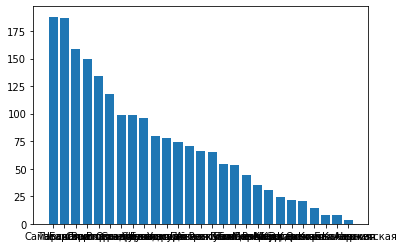

In [22]:
regions = df['REGION'].value_counts()
print('Количество регионов:', regions.shape[0])
_ = plt.bar(regions.index, regions)

In [23]:
regions

Самарская                   188
Татарстан                   187
Челябинская                 159
Башкортостан                150
Саратовская                 134
Волгоградская               118
Воронежская                  99
Оренбургская                 99
Ставропольский               96
Ульяновская                  80
Белгородская                 78
Удмуртская                   74
Чувашская Республика         71
Пензенская                   66
Астраханская                 65
Коми                         54
Липецкая                     53
Тамбовская                   44
Марий Эл                     35
Рязанская                    31
Мордовия                     24
Курганская                   22
Северная Осетия - Алания     21
Кабардино-Балкарская         14
Кировская                     8
Карачаево-Черкесская          8
Калмыкия                      3
Name: REGION, dtype: int64

In [24]:
df_cities = city_coords[city_coords['Город'].isin(df['CITY'].value_counts().index.to_list())]
print(df_cities.shape)
df_cities.head(3)

(79, 21)


,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,Код ФИАС,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
38,414000.0,обл,Астраханская,NaN,NaN,г,Астрахань,NaN,NaN,3000000100000,a101dd8b-3aee-4bda-9c61-9df106f145ff,4: город,2,12401000000,12701000.0,3000,UTC+4,46.365581,48.055998,Южный,520662
46,452000.0,Респ,Башкортостан,р-н,Белебеевский,г,Белебей,NaN,NaN,200900100000,11e85c3e-c276-43b3-94e8-6b7f6cde5ac1,4: город,1,80405000000,80609101.0,200,UTC+5,54.103383,54.111188,Приволжский,60183
52,453200.0,Респ,Башкортостан,р-н,Ишимбайский,г,Ишимбай,NaN,NaN,202600100000,b3d2e10f-752d-4b90-b54b-9d6545f38ae0,4: город,1,80420000000,80631101.0,261,UTC+5,53.454631,56.043874,Приволжский,66259


Отобразим города на карте.

In [25]:
city_points = [Point(xy) for xy in zip(df_cities['Долгота'], df_cities['Широта'])]
city_points[:5]

In [26]:
crs={'init': 'epsg:4326'} # Coordinate Reference Systems
geo_df = gpd.GeoDataFrame(df_cities, crs=crs, geometry=city_points)
geo_df.head()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,Код ФИАС,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население,geometry
38,414000.0,обл,Астраханская,NaN,NaN,г,Астрахань,NaN,NaN,3000000100000,a101dd8b-3aee-4bda-9c61-9df106f145ff,4: город,2,12401000000,1.270100e+07,3000,UTC+4,46.365581,48.055998,Южный,520662,POINT (48.05600 46.36558)
46,452000.0,Респ,Башкортостан,р-н,Белебеевский,г,Белебей,NaN,NaN,200900100000,11e85c3e-c276-43b3-94e8-6b7f6cde5ac1,4: город,1,80405000000,8.060910e+07,200,UTC+5,54.103383,54.111188,Приволжский,60183,POINT (54.11119 54.10338)
52,453200.0,Респ,Башкортостан,р-н,Ишимбайский,г,Ишимбай,NaN,NaN,202600100000,b3d2e10f-752d-4b90-b54b-9d6545f38ae0,4: город,1,80420000000,8.063110e+07,261,UTC+5,53.454631,56.043874,Приволжский,66259,POINT (56.04387 53.45463)
53,453300.0,Респ,Башкортостан,NaN,NaN,г,Кумертау,NaN,NaN,200000700000,48e38991-07fd-4aaa-b240-a7280e4a823f,4: город,0,80423000000,8.072300e+07,261,UTC+5,52.756554,55.796992,Приволжский,62854,POINT (55.79699 52.75655)
56,452680.0,Респ,Башкортостан,NaN,NaN,г,Нефтекамск,NaN,NaN,200000300000,2c9997d2-ce94-431a-96c9-722d2238d5c8,4: город,0,80427000000,8.072700e+10,264,UTC+5,56.088307,54.248339,Приволжский,121757,POINT (54.24834 56.08831)


Выделим города, находящиеся на крайних позициях

In [27]:
boundary_cities = [
  df_cities[df_cities['Долгота'].min() == df_cities['Долгота']]['Город'].values[0],
  df_cities[df_cities['Долгота'].max() == df_cities['Долгота']]['Город'].values[0],
  df_cities[df_cities['Широта'].min() == df_cities['Широта']]['Город'].values[0],
  df_cities[df_cities['Широта'].max() == df_cities['Широта']]['Город'].values[0],
]

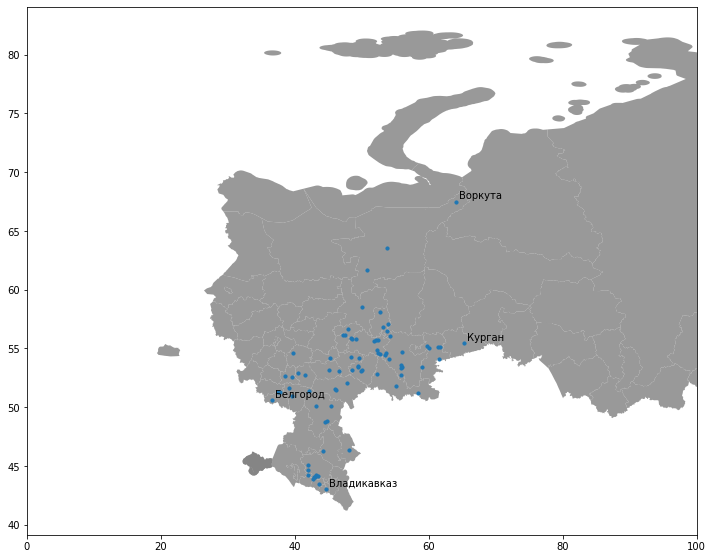

In [28]:
fig, ax = plt.subplots(figsize=(12,20))
ax.set_xlim([0, 100]) # ограничим вывод, т.к. в других местах нет точек
gdf.plot(ax=ax, alpha=.8, color='grey')
_ = geo_df.plot(ax=ax, markersize=10, marker='o')

for x, y, label in zip(df_cities['Долгота'], df_cities['Широта'], df_cities['Город']):
  if label in boundary_cities:
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

plt.show()

Построим рассеяние целевого признака по коордианатам

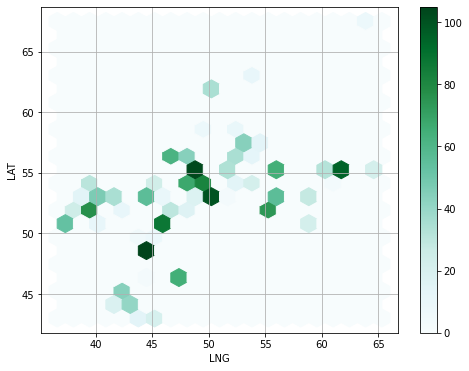

In [38]:
df.plot(x='LNG', y='LAT', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)

Посмотрим на рассеяние целевого признака по регионам и городам

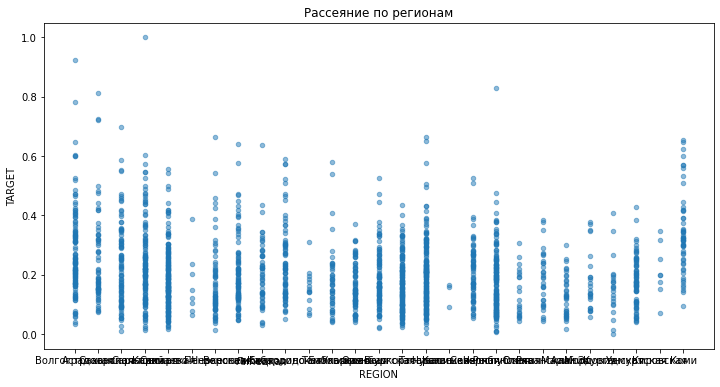

In [ ]:
ax = df.plot.scatter(x='REGION', y='TARGET', figsize=(12, 6), marker='o', alpha=0.5)
ax.set_xlabel('REGION')
ax.set_ylabel('TARGET')
_ = ax.set_title('Рассеяние по регионам')

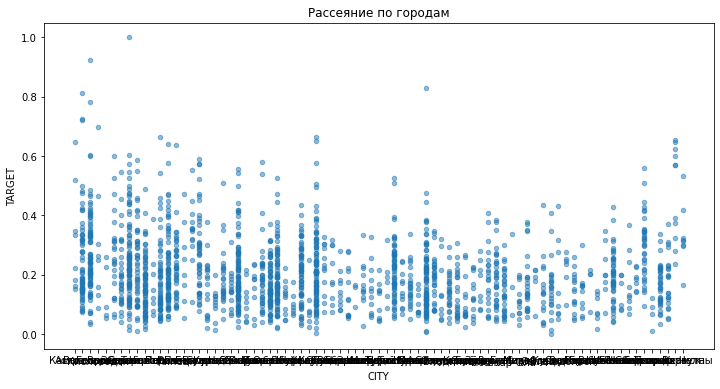

In [ ]:
ax = df.plot.scatter(x='CITY', y='TARGET', figsize=(12, 6), marker='o', alpha=0.5)
ax.set_xlabel('CITY')
ax.set_ylabel('TARGET')
_ = ax.set_title('Рассеяние по городам')

Рассеяние на граничных городах

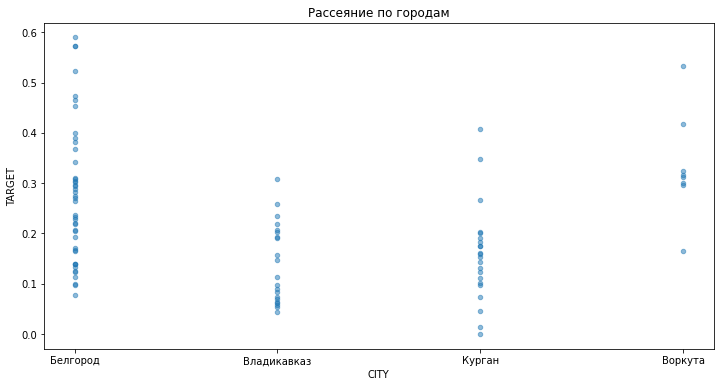

In [ ]:
ax = df[df['CITY'].isin(boundary_cities)].plot.scatter(x='CITY', y='TARGET', figsize=(12, 6), marker='o', alpha=0.5)
ax.set_xlabel('CITY')
ax.set_ylabel('TARGET')
_ = ax.set_title('Рассеяние по городам')

Возможно, есть различия в распределнии целевого признака для противолежащих городов: Владикавказ - Воркута и Белгород - Курган

Проверим на нормальность распределения данных в этих городах

In [ ]:
alpha = .05
for city in boundary_cities:
  k2, p = stats.normaltest(df[df['CITY'] == city]['TARGET'])
  print(city+" p-value =", p)
  if p < alpha:
    print('Отклоняем нулевую гипотезу и считаем, что распределение ненормальное')
  else:
    print('Принимаем нулевую гипотезу и считаем, что распределение нормальное')
  print()


Белгород p-value = 0.13942279324787205
Принимаем нулевую гипотезу и считаем, что распределение нормальное

Курган p-value = 0.06734029047232691
Принимаем нулевую гипотезу и считаем, что распределение нормальное

Владикавказ p-value = 0.28864381076904805
Принимаем нулевую гипотезу и считаем, что распределение нормальное

Воркута p-value = 0.3587882225700103
Принимаем нулевую гипотезу и считаем, что распределение нормальное



/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


**Взглянем на "Владикавказ - Воркута"**

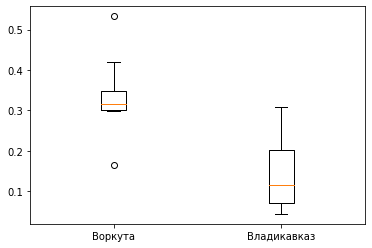

In [ ]:
_ = plt.boxplot([
  df[df['CITY'] == 'Воркута']['TARGET'], 
  df[df['CITY'] == 'Владикавказ']['TARGET']
])
_ = plt.xticks([1, 2], ['Воркута', 'Владикавказ'])

In [ ]:
print('Дисперсия Владикавказ:\t', np.var(df[df['CITY'] == 'Владикавказ']['TARGET']))
print('Дисперсия Воркута:\t', np.var(df[df['CITY'] == 'Воркута']['TARGET']))

Дисперсия Владикавказ:	 0.00596039796852318
Дисперсия Воркута:	 0.009844276053173466


Дисперсию считаем различной

In [ ]:
res = stats.ttest_ind(df[df['CITY'] == 'Владикавказ']['TARGET'], 
                      df[df['CITY'] == 'Воркута']['TARGET'],
                      equal_var=False)
print(f'p-value: {res.pvalue / 2:.4f}')

p-value: 0.0004


**Взглянем на "Белгород - Курган"**

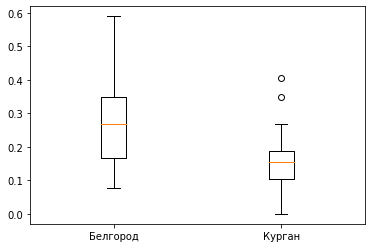

In [ ]:
_ = plt.boxplot([
  df[df['CITY'] == 'Белгород']['TARGET'], 
  df[df['CITY'] == 'Курган']['TARGET']
])
_ = plt.xticks([1, 2], ['Белгород', 'Курган'])

In [ ]:
print('Дисперсия Белгород:\t', np.var(df[df['CITY'] == 'Белгород']['TARGET']))
print('Дисперсия Курган:\t', np.var(df[df['CITY'] == 'Курган']['TARGET']))

Дисперсия Белгород:	 0.01852582452844428
Дисперсия Курган:	 0.00875741688920592


Дисперсия считаем различной

In [ ]:
res = stats.ttest_ind(df[df['CITY'] == 'Белгород']['TARGET'], 
                      df[df['CITY'] == 'Курган']['TARGET'],
                      equal_var=False)
print(f'p-value: {res.pvalue / 2:.4f}')

p-value: 0.0001


Возможно между городами отдаленных друг от друга есть разница в распределении целевого признака. <br>
Попробуем разбить города на кластеры по координатам.

### Разбиение городов на кластеры по координатам (K-means)

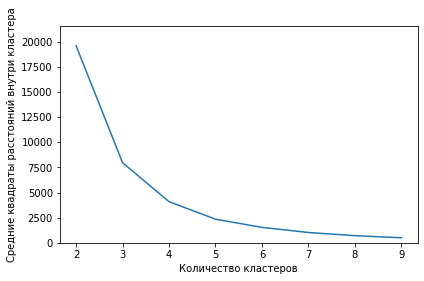

In [40]:
km_data = df[df['Разбивка'] == 'Обучение'][['LNG', 'LAT']]
inertia = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(km_data)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 10), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Количество кластеров')
plt.ylabel('Средние квадраты расстояний внутри кластера')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

Оптимальное колиечтсво кластеров вероятно равно 4

In [41]:
km = KMeans(n_clusters=4, random_state=42).fit(km_data)
df['CLUSTER'] = km.predict(df[['LNG', 'LAT']])
df.head(3)

,ID,CITY,NUM_1,NUM_2,NUM_3,NUM_4,NUM_5,CAT_1,CAT_2,CAT_3,CAT_4,CAT_5,NUM_6,CAT_7,NUM_7,NUM_8,CAT_8,NUM_9,CAT_9,CAT_10,NUM_10,NUM_11,NUM_12,CAT_11,CAT_12,CAT_13,CAT_14,CAT_15,CAT_16,CAT_17,TARGET,Разбивка,REGION,LAT,LNG,CLUSTER
0,1,Камышин,0.235583,0.303522,0.44584,0.500000,0.021977,0,0,0,0,0,0.349891,0,0.000000,0.0,1,0.048239,0,0,0.752511,0.790898,0.275362,1,0,0,0,0,0,1,0.647650,Обучение,Волгоградская,50.065126,45.384382,2
1,2,Астрахань,0.372025,0.254108,0.00000,0.877551,0.008615,2,0,0,0,1,0.000000,1,0.137931,0.0,0,0.401651,0,0,0.805380,0.813467,0.369565,0,0,0,0,0,1,1,0.812763,Обучение,Астраханская,46.365581,48.055998,2
2,3,Волгоград,0.270541,0.463390,0.17554,0.785714,0.002930,1,0,0,0,0,0.090554,0,0.224138,0.0,1,0.801169,0,1,0.000000,0.850329,0.434783,0,0,0,0,0,0,0,0.445332,Обучение,Волгоградская,48.707200,44.517021,2


Сохраняем кластеризатор

In [49]:
dump(km, 'clusterize.joblib')

['clusterize.joblib']

Посмотрим как разбились города

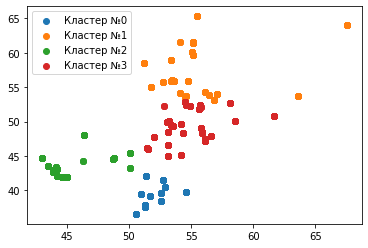

In [ ]:
cluster_legends = []
for i in range(4):
  cluster_legends.append('Кластер №'+str(i))
  plt.scatter(df[df['CLUSTER']==i]['LAT'], df[df['CLUSTER']==i]['LNG'])
plt.legend(cluster_legends)
plt.show()

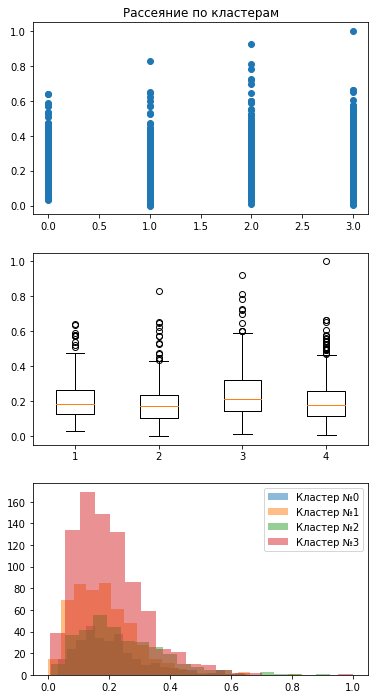

In [ ]:
fig, axs = plt.subplots(3,1)
fig.set_figwidth(6)
fig.set_figheight(12)

_ = axs[0].scatter(df['CLUSTER'], df['TARGET'])
axs[0].set_title('Рассеяние по кластерам')

_ = axs[1].boxplot([
  df[df['CLUSTER'] == 0]['TARGET'], 
  df[df['CLUSTER'] == 1]['TARGET'], 
  df[df['CLUSTER'] == 2]['TARGET'], 
  df[df['CLUSTER'] == 3]['TARGET']
])

for i in range(4):
  _ = axs[2].hist(df[df['CLUSTER'] == i]['TARGET'], alpha=.5, bins=20)
axs[2].legend(cluster_legends)


Проверим являются ли кластеры нормально распределенными

In [ ]:
alpha = .05
for i in range(4):
  k2, p = stats.normaltest(df[df['CLUSTER'] == i]['TARGET'])
  print('Кластер №'+str(i)+" p-value =", p)
  if p < alpha:
    print('Отклоняем нулевую гипотезу и считаем, что распределение ненормальное')
  else:
    print('Принимаем нулевую гипотезу и считаем, что распределение нормальное')
  print()


Кластер №0 p-value = 8.895468526513704e-15
Отклоняем нулевую гипотезу и считаем, что распределение ненормальное

Кластер №1 p-value = 1.278976953377986e-35
Отклоняем нулевую гипотезу и считаем, что распределение ненормальное

Кластер №2 p-value = 5.53535048531842e-19
Отклоняем нулевую гипотезу и считаем, что распределение ненормальное

Кластер №3 p-value = 1.6114172703571318e-51
Отклоняем нулевую гипотезу и считаем, что распределение ненормальное



In [ ]:
df.pivot_table(values=['TARGET'], index=['CLUSTER'], aggfunc=['median', 'mean'])

,median,mean
,TARGET,TARGET
CLUSTER,,
0,0.185323,0.208191
1,0.170947,0.184802
2,0.208689,0.241879
3,0.176665,0.197970


Так как данные распределенны ненормально, то воспользуемся критеием Краскела—Уоллиса, который является непараметрическим, позволяет сравнивать медианы нескольких выборок. <br>
Нулевая гипотеза - все выборки (медианы) целевой переменной для разных кластеров одинаковы 

In [ ]:
s, p = stats.kruskal(
  df[df['CLUSTER'] == 0]['TARGET'], 
  df[df['CLUSTER'] == 1]['TARGET'], 
  df[df['CLUSTER'] == 2]['TARGET'], 
  df[df['CLUSTER'] == 3]['TARGET']
)
alpha = .05
print('p-value:', p)
if p < alpha:
  print('Отклоняем нулевую гипоетзу')
else:
  print('Принимаем нулевую гипоетзу')

p-value: 7.850297944662336e-08
Отклоняем нулевую гипоетзу


Можно предположить что медианные значения целевого признака отличаются для разных кластеров

## 2.4 Вещественные признаки

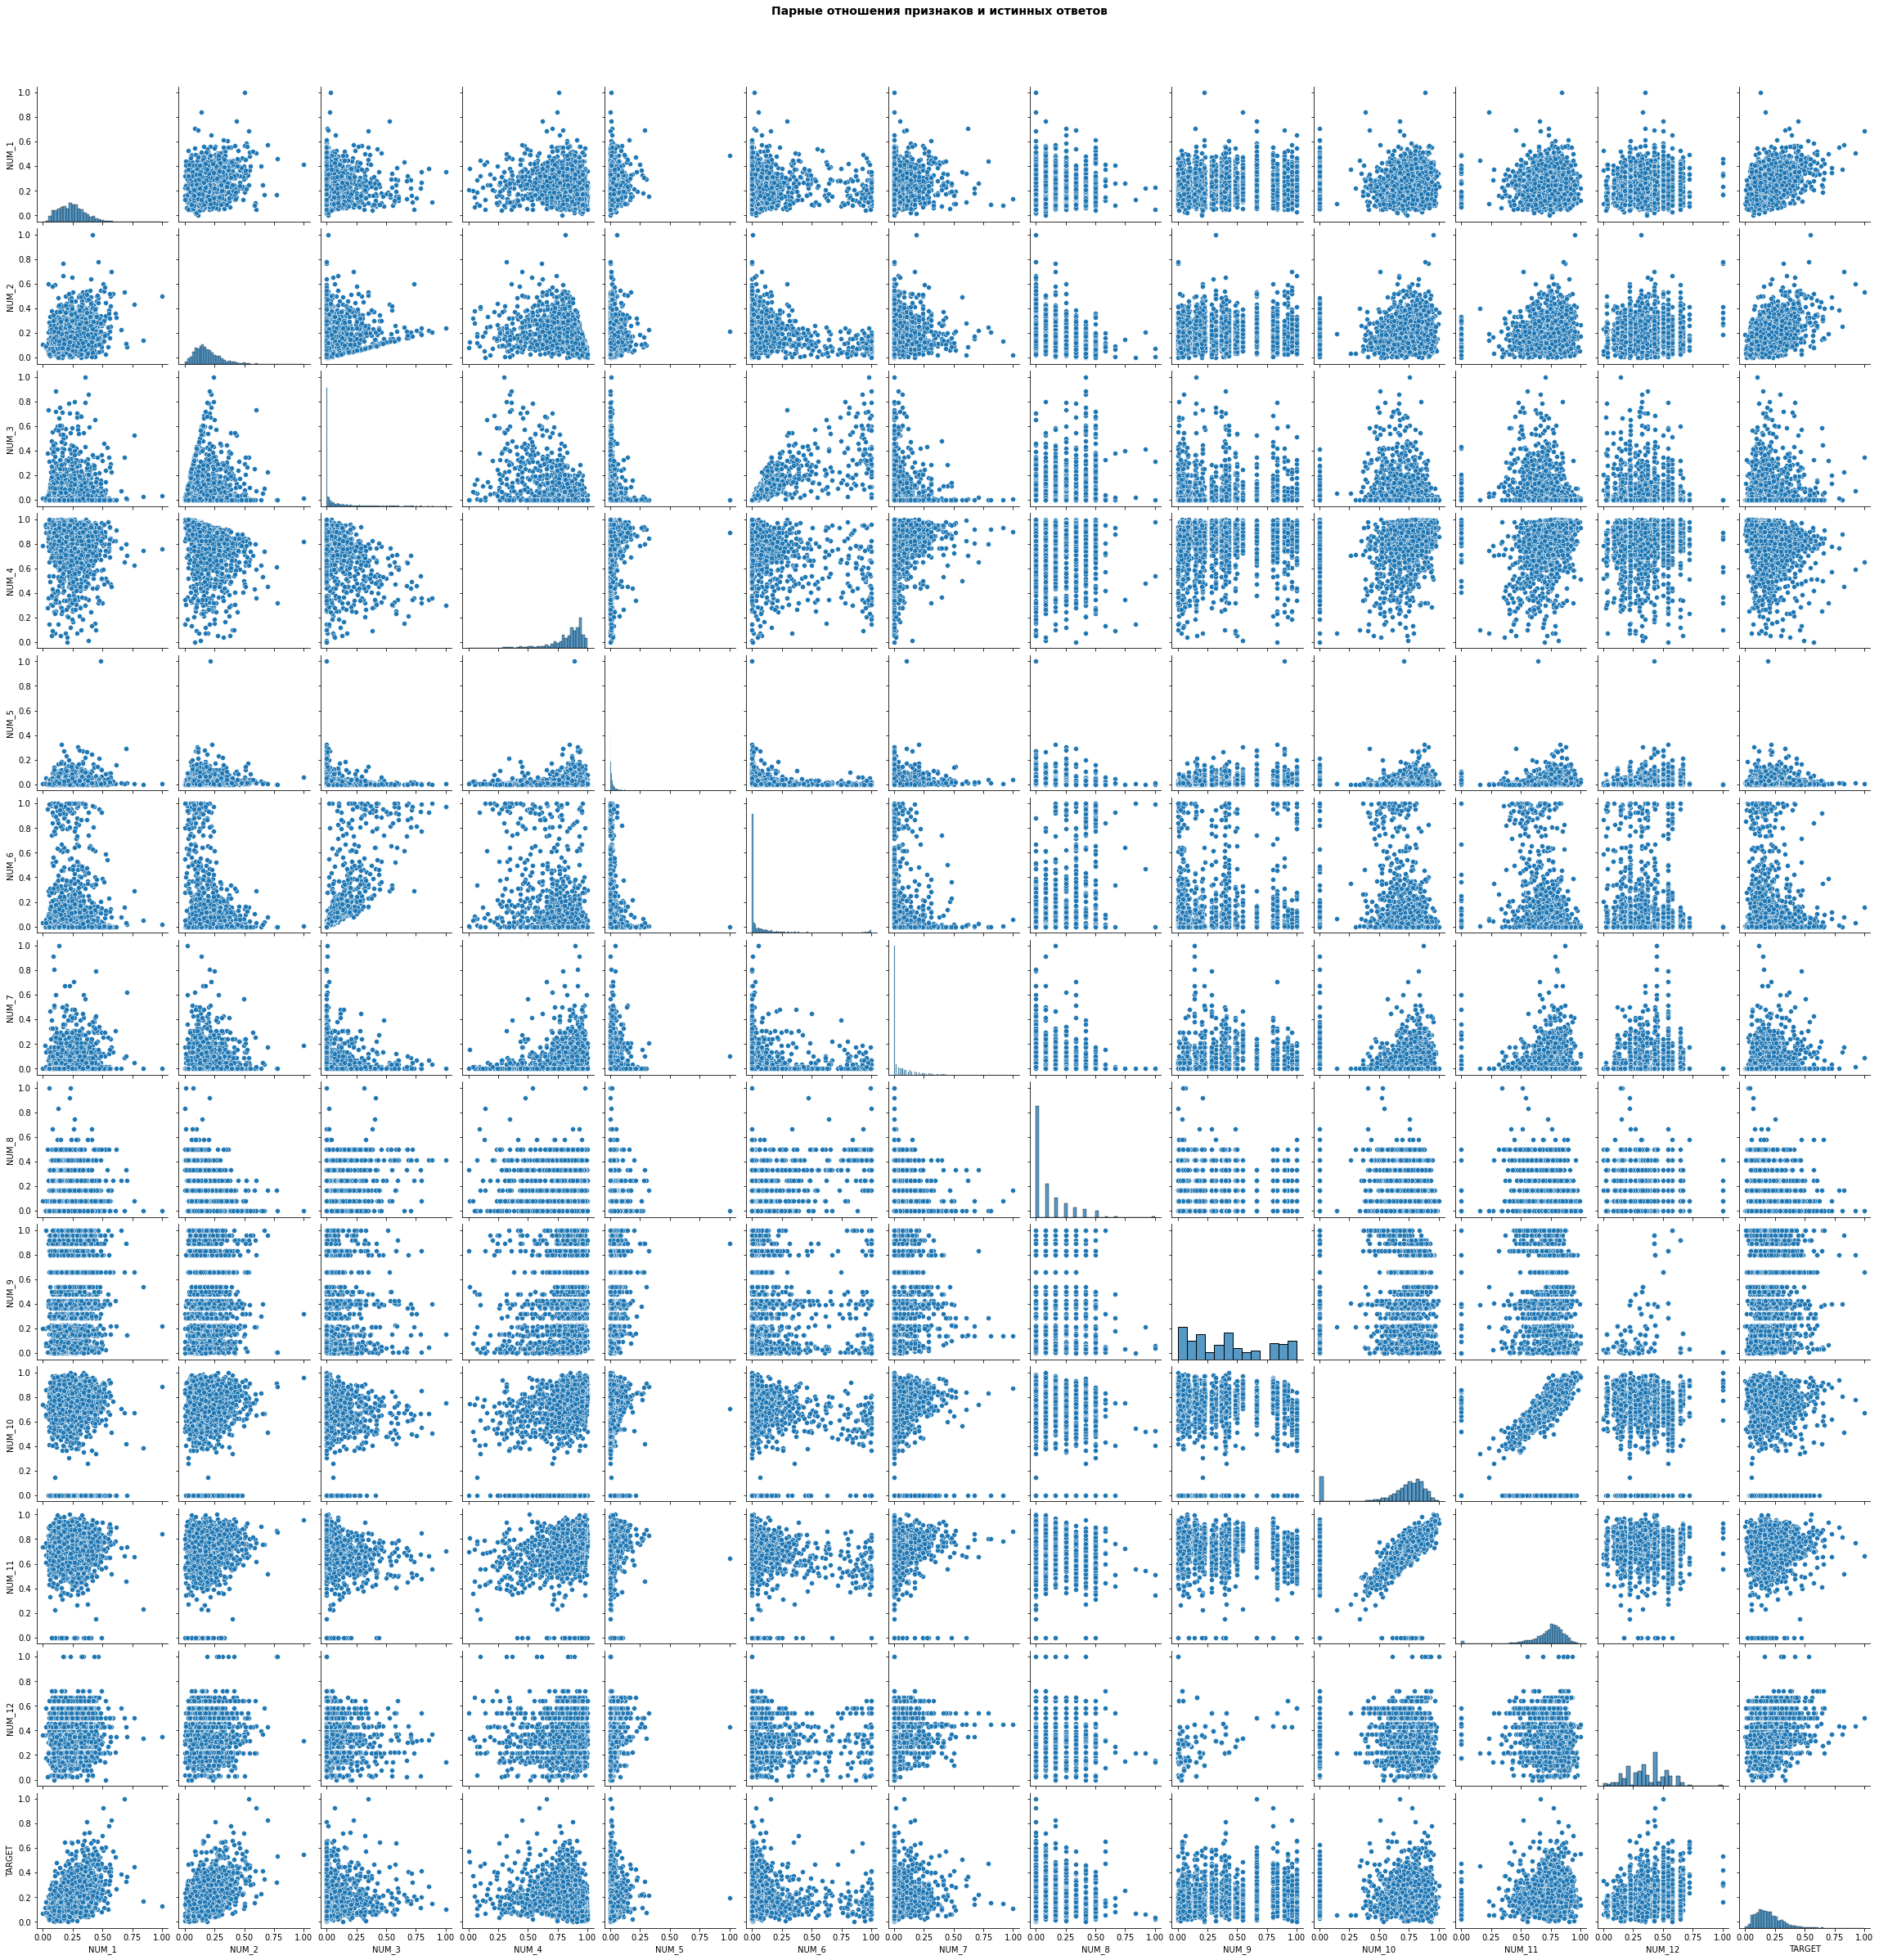

CPU times: user 1min 11s, sys: 651 ms, total: 1min 12s
Wall time: 1min 11s


In [ ]:
%%time
sns_plot = sns.pairplot(df[num_features+['TARGET']])
sns_plot.fig.suptitle(
  'Парные отношения признаков и истинных ответов', 
  y = 1.03, 
  fontsize=14, 
  fontweight='bold'
)
plt.show()

Посмотрим корреляцию признаков

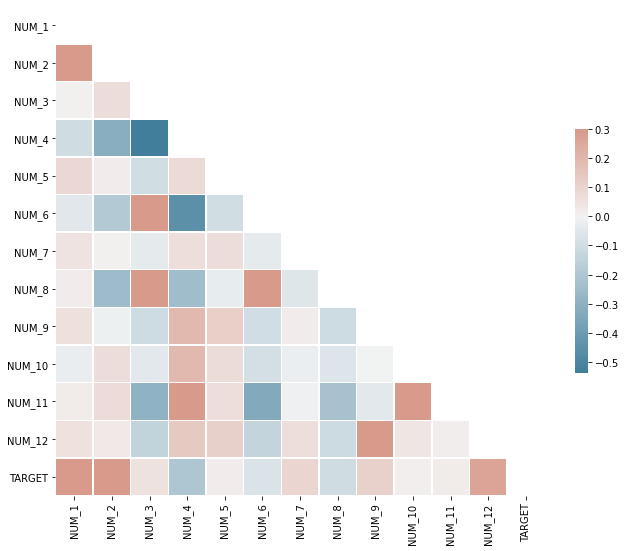

In [ ]:
#method{‘pearson’, ‘kendall’, ‘spearman’} 
df_corr = df[num_features+['TARGET']].corr(method='pearson')
mask = np.triu(np.ones_like(df_corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Видно что есть слабые корреляции между целевым признаком и `NUM_1`, `NUM_2`, `NUM_12`. Также есть слабые корреляция между нецелевыми признаками 

Построим графики рассеяния и распределения по целевому признаку

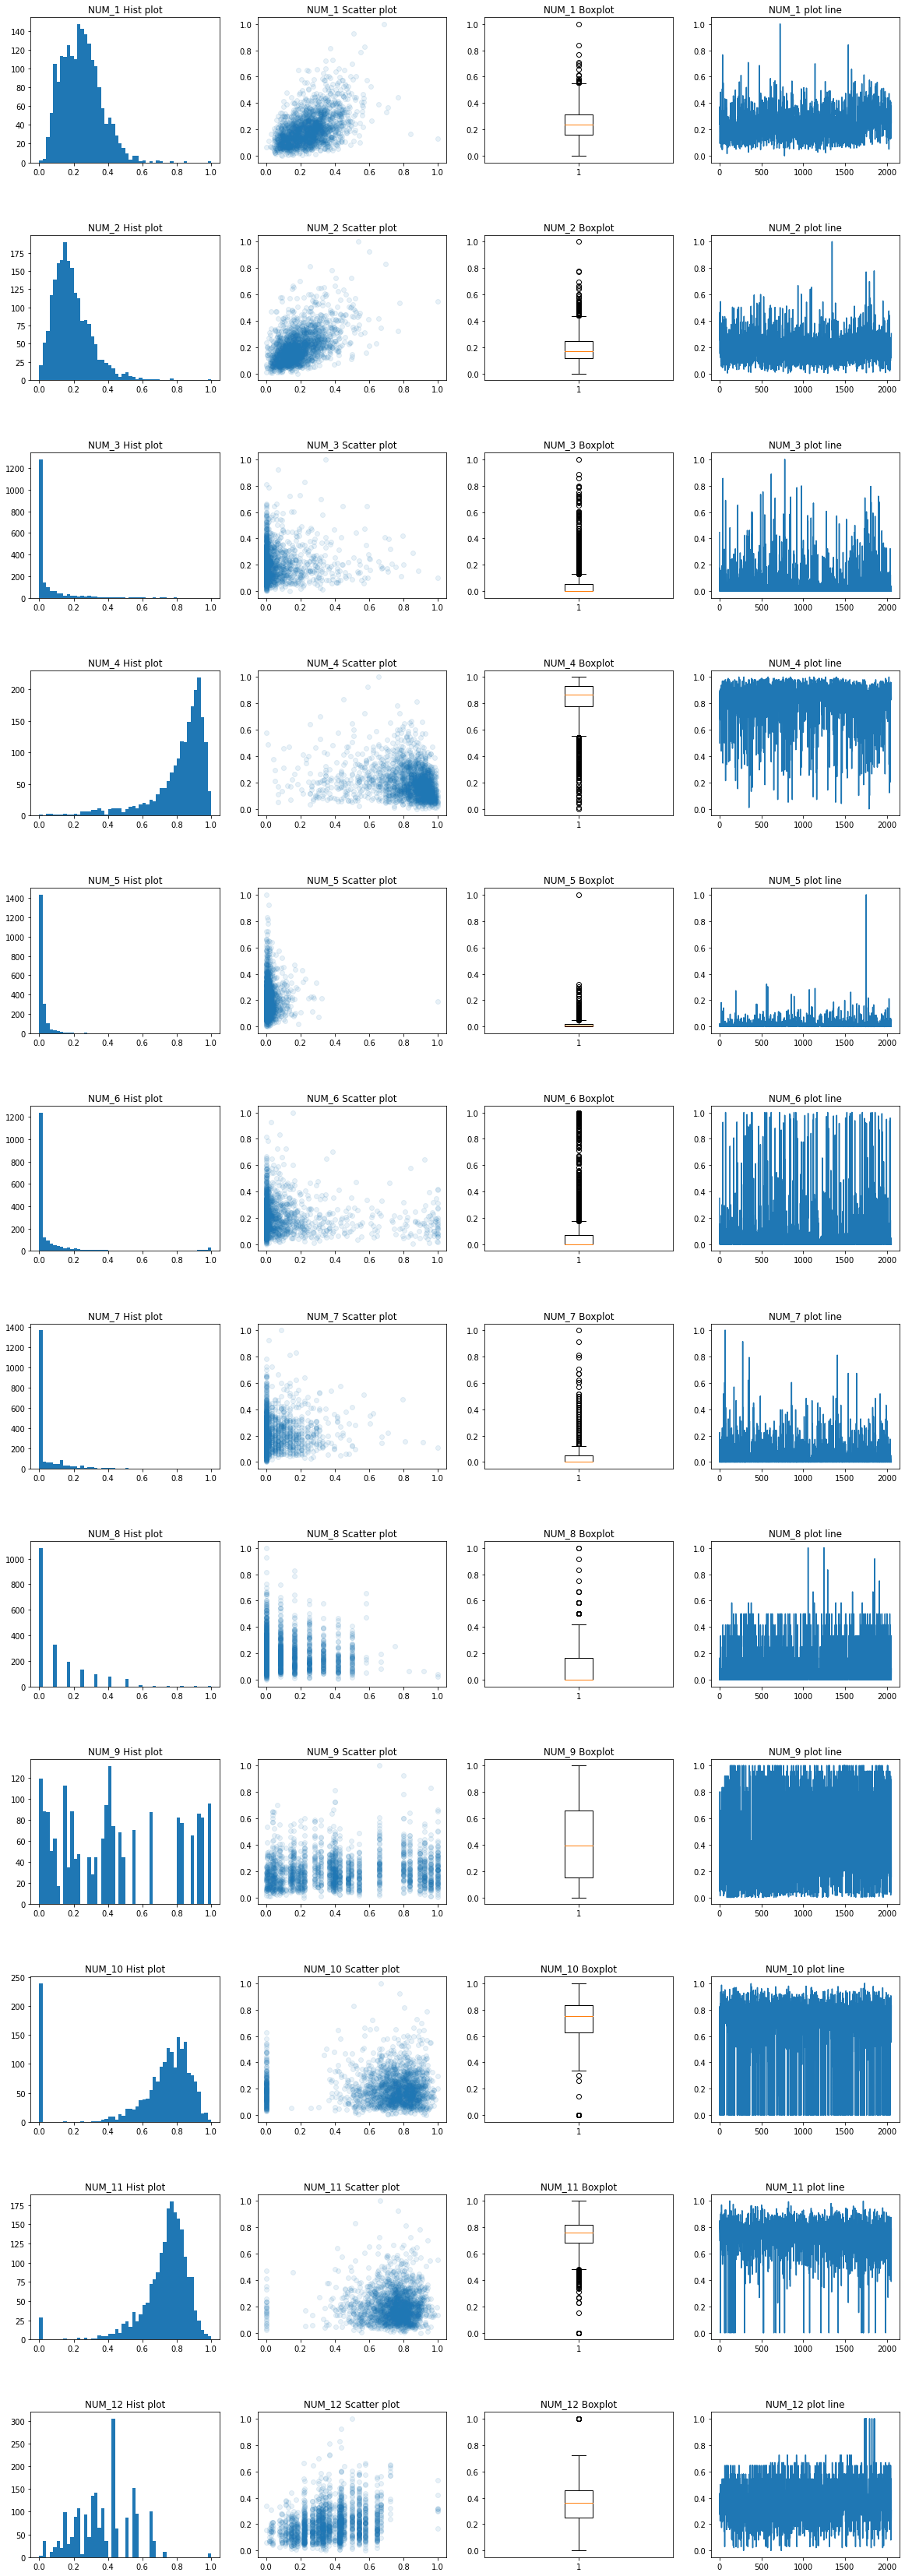

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
axs = [0 for i in range(len(num_features))]
fig, axs = plt.subplots(len(axs), 4)

fig.set_figwidth(20)
fig.set_figheight(60)

plt.subplots_adjust(hspace=.5)

for i, num_name in enumerate(num_features):
  df_num = df[num_name]

  axs[i][0].set(title=num_name+' Hist plot')
  _ = axs[i][0].hist(df_num, bins=50)

  axs[i][1].set(title=num_name+' Scatter plot')
  _ = axs[i][1].scatter(df_num, df['TARGET'], alpha=.1)

  axs[i][2].set(title=num_name+' Boxplot')
  _ = axs[i][2].boxplot(df_num)

  axs[i][3].set(title=num_name+' plot line')
  _ = axs[i][3].plot(df_num)

plt.show()

In [ ]:
df['NUM_8'].value_counts()

0.000000    1083
0.083333     327
0.166667     192
0.250000     132
0.333333      97
0.416667      74
0.500000      61
0.583333       7
0.666667       3
1.000000       2
0.916667       1
0.833333       1
0.750000       1
Name: NUM_8, dtype: int64

- `NUM_1` и `NUM_2` слабо коррелируют между собой и целевым признаком. Также имеют схожие гистгораммы и диаграммы рассеяния с целевым признаком
- `NUM_10` и `NUM_11` имеют схожие гистгораммы и диаграммы рассеяния с целевым признаком.
- `NUM_3`, `NUM_5`, `NUM_6` и `NUM_7` имеют схожие гистгораммы и диаграммы рассеяния с целевым признаком.

- В `NUM_10` наблюдается большое количество нулей. Но так как неизвестно что это и откуда данные, нельзя сказать что это нормальное явления или плохие данные
- В `NUM_11` также есть небольшое скопление нулей
- В некоторых других признаках тоже видно большое количество нулей (или единиц)
- `NUM_8` - кажется является дискретной величиной.

## 2 Вывод
- Категориальные признаки надо кодировать с помощью One-hot-encoding. (Для городов, регоинов и кластеров тоже)
- Вещественные признаки лежат в одном диапазон - их масштабировать не надо. Но можно использовать понижение размерности с помощью метода главных компонент
- Добавлены регионы и кластеризация, которая разбила города на 4 участка. Это сделано, потому что есть предположение что положение городов имеет значение.

# 3 Подготовка данных для обучения

In [42]:
df_train = df[df['Разбивка'] == 'Обучение']
df_test = df[df['Разбивка'] == 'Тест']

## 3.1 One-hot-encoding

One-hot-encoding делаем для всех ктаегориальных признаков, в том числе городов, регионов и кластеров. <br>
Также метод `fit` применяем не к обучающей выборке, а ко всем данным, т.к. в обучающей и тестовой выборках содержатся разные городоа. Например, Воркуты нет в обучающей выборке.

In [44]:
encoding_features = cat_features+['CITY', 'REGION', 'CLUSTER']
ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(df[encoding_features])
train_ohe = ohe.transform(df_train[encoding_features])
df_train_ohe = pd.DataFrame(train_ohe, columns=ohe.get_feature_names()).reset_index(drop=True)
df_train_ohe.head()

,x0_1,x0_2,x0_3,x0_4,x1_1,x2_1,x3_1,x3_2,x4_1,x4_2,x5_1,x6_1,x7_1,x8_1,x9_1,x10_1,x11_1,x12_1,x13_1,x14_1,x15_1,x16_Астрахань,x16_Балаково,x16_Белгород,x16_Белебей,x16_Борисоглебск,x16_Бугульма,x16_Бузулук,x16_Владикавказ,x16_Волгоград,x16_Волжск,x16_Волжский,x16_Воркута,x16_Воронеж,x16_Воткинск,x16_Георгиевск,x16_Глазов,x16_Губкин,x16_Димитровград,x16_Елабуга,...,x16_Тольятти,x16_Троицк,x16_Туймазы,x16_Ульяновск,x16_Уфа,x16_Ухта,x16_Чебоксары,x16_Челябинск,x16_Черкесск,x16_Элиста,x16_Энгельс,x17_Башкортостан,x17_Белгородская,x17_Волгоградская,x17_Воронежская,x17_Кабардино-Балкарская,x17_Калмыкия,x17_Карачаево-Черкесская,x17_Кировская,x17_Коми,x17_Курганская,x17_Липецкая,x17_Марий Эл,x17_Мордовия,x17_Оренбургская,x17_Пензенская,x17_Рязанская,x17_Самарская,x17_Саратовская,x17_Северная Осетия - Алания,x17_Ставропольский,x17_Тамбовская,x17_Татарстан,x17_Удмуртская,x17_Ульяновская,x17_Челябинская,x17_Чувашская Республика,x18_1,x18_2,x18_3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Сохраняем кодировщик

In [45]:
dump(ohe, 'cat-encoder.joblib')

['cat-encoder.joblib']

## 3.2 Понижение размерности

In [46]:
pca = PCA(.95, svd_solver='full') # Количество компонентов будет выбрано таким образом, чтобы сохранилось 95% информации
pca.fit(df_train[num_features]) 

PCA(n_components=0.95, svd_solver='full')

In [47]:
pca_train = pca.transform(df_train[num_features]) 
pca_columns = ['Component '+str(i) for i in range(pca.n_components_)]
df_train_pca = pd.DataFrame(pca_train, columns=pca_columns).reset_index(drop=True)
df_train_pca.head()

,Component 0,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8
0,0.490411,0.036679,0.315760,0.275608,-0.109385,0.060644,-0.212649,0.003230,-0.037111
1,-0.046481,-0.199563,-0.052421,0.095848,-0.061133,0.031249,0.056691,0.120378,-0.010859
2,-0.290540,0.610891,-0.291179,0.199136,-0.290565,0.012797,-0.064302,0.125108,0.109934
3,-0.348122,0.003760,0.239119,0.128527,-0.122000,-0.034437,0.021585,0.057973,0.010205
4,-0.357242,0.046569,0.179884,-0.068432,-0.049431,-0.066287,0.005130,-0.029076,-0.021508


Сохраняем преобразователь PCA

In [48]:
dump(pca, 'num-pca.joblib')

['num-pca.joblib']

Взглянем на дисперсии компонент. В данном случае дисперсия характеризует важность компоненты

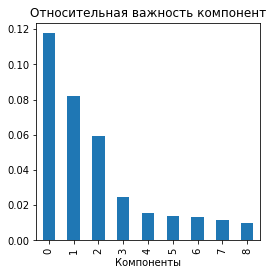

In [ ]:
explained_variance = pd.DataFrame(pca.explained_variance_)
ax = explained_variance.plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Компоненты')

plt.title('Относительная важность компонент')
plt.show()

Большой вклад вносят первые три компоненты

Взглянем какие нагрузки вносят признаки в кажду компоненту

In [ ]:
loadings = pd.DataFrame(pca.components_, columns=num_features)

Вклад признаков в изменчивость первых трёх компонент 

In [ ]:
loadings.iloc[:3].abs().sum(axis=0).sort_values(ascending=False)

NUM_10    1.453994
NUM_9     1.321293
NUM_6     1.158108
NUM_4     0.678944
NUM_3     0.588199
NUM_8     0.529180
NUM_11    0.415913
NUM_12    0.406486
NUM_2     0.058016
NUM_7     0.046908
NUM_5     0.026663
NUM_1     0.021761
dtype: float64

Вклад признаков в изменчивость первых восьми компонент 

In [ ]:
loadings.abs().sum(axis=0).sort_values(ascending=False)

NUM_6     2.350647
NUM_8     2.320452
NUM_4     2.160218
NUM_1     2.052890
NUM_11    1.981300
NUM_9     1.853246
NUM_7     1.814665
NUM_10    1.788546
NUM_12    1.769574
NUM_3     1.210478
NUM_2     0.944030
NUM_5     0.106706
dtype: float64

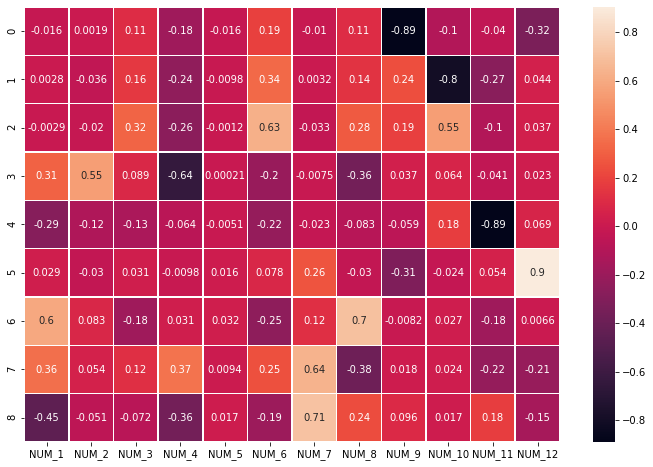

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
_ = sns.heatmap(loadings, annot=True, linewidths=.5, ax=ax)

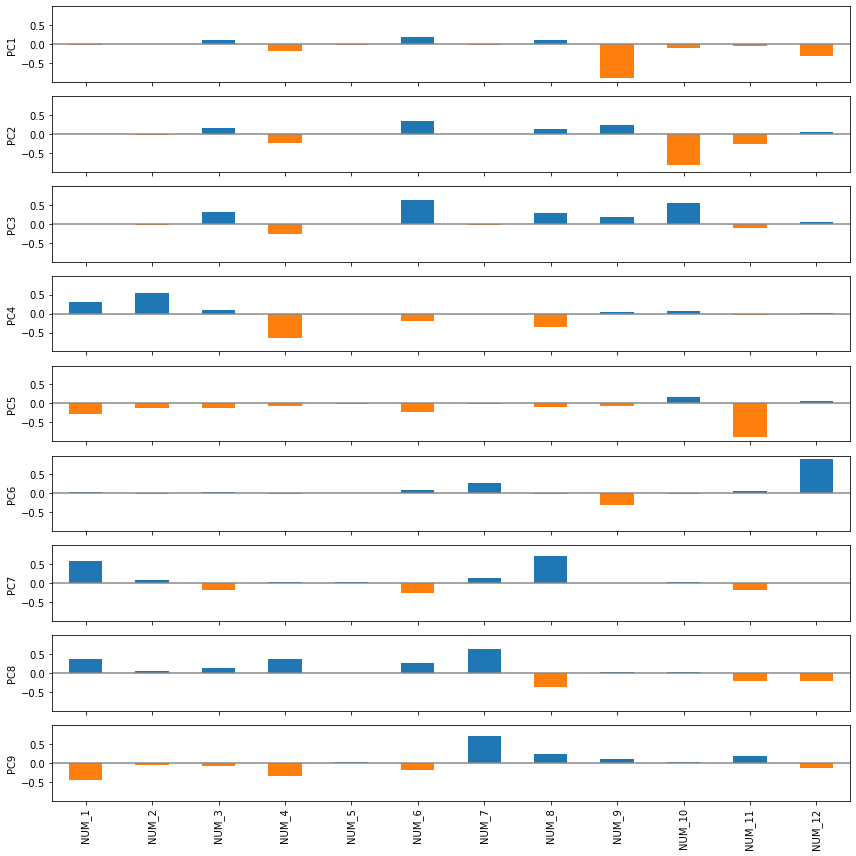

In [ ]:
maxPC = 1.1 * np.max(np.max(np.abs(loadings)))

f, axes = plt.subplots(9, 1, figsize=(12, 12), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

Признаки `NUM_6`, `NUM_9` и `NUM_10` вносят больше всего наргрзки в первых трех компонентах. <br>
Также в целом можно сказать, что `NUM_5` вносит наименьшую нагрузку

# 4 Обучение моделей 

## 4.1 Подготовка выборок для обучения и теста

In [ ]:
# Делаем сброс индексов, чтобы не было проблем с конкатенацией датафреймов
df_train.reset_index(inplace=True, drop=True)

# обучающая выборка
X_train = pd.concat([df_train_ohe, df_train_pca], axis=1)
y_train = df_train['TARGET']

# тестовая выборка
# кодируем категориальные признаки
test_ohe = ohe.transform(df_test[encoding_features])
df_test_ohe = pd.DataFrame(test_ohe, columns=ohe.get_feature_names()).reset_index(drop=True)

# трансформируем вещественные признаки
test_pca = pca.transform(df_test[num_features])
df_test_pca = pd.DataFrame(test_pca, columns=pca_columns).reset_index(drop=True)

# собираем в тестовую выборку
X_test = pd.concat([df_test_ohe, df_test_pca], axis=1)
y_test = df_test['TARGET']



In [ ]:
print('Пропуски после конкатенации')
print(X_train[X_train.isnull().any(axis=1)].values)
print(X_test[X_test.isnull().any(axis=1)].values)

Пропуски после конкатенации
[]
[]


## 4.2 Модель для оценки

Собственная метрика оценки 

In [ ]:
def customScorer(y_true, y_pred):
  y_pred = y_pred.flatten()
  n_elems = y_true.shape[0]
  ratio_list = y_true/y_pred
  prefer_ratio = ratio_list[(ratio_list <= 1.2) & (ratio_list >= .8)]
  return prefer_ratio.shape[0]/n_elems

custom_scorer = make_scorer(customScorer, greater_is_better=True)

С помощью приведенных ниже вычислений ("константной" модели) зададим пороги для наших будущих оценок 

In [ ]:
train_median = y_train.median()
y_pred = np.array([train_median for _ in range(len(y_test))])
print('Константа MAPE:\t\t', mape(y_test, y_pred))
print('Константа Custom:\t', customScorer(y_test, y_pred))

y_pred = np.random.choice(y_train, len(y_test))
print('Случайная выборка MAPE:\t', mape(y_test, y_pred))
print('Случайная выборка Custom:', customScorer(y_test, y_pred))

Константа MAPE:		 0.9180706013722764
Константа Custom:	 0.24922118380062305
Случайная выборка MAPE:	 1.4285235510076557
Случайная выборка Custom: 0.17133956386292834


Наша модель должна иметь оценку MAPE не более 92%, а сосбвтенной метрику не менее 25% 

Запишим функцию, которая будемт вычислять на какое количество пунктов обученная модель лучше "константной" модели.

In [ ]:
def getProfit(a, b):
  """
  a - метрика MAPE на предсказанной выборке
  b - сосбтенная метрика на предсказанной выборке
  """
  a = np.round(a*100) # Конвертируем в проценты
  b = np.round(b*100) # Конвертируем в проценты
  return (92 - a) + (b - 25)

print('Максимально возможный выигрыш:', getProfit(0, 1))

Максимально возможный выигрыш: 167


## 4.3 Выбор модели

Попробуем разные модели: 
- линейную регрессию как саму быструю.
- случайный лес и некоторые бустинги. Так как данных немного стоит использовать бустинги с построением деревьев методом depth-wise.
- простую нейронную сеть

Для простоых моделей воспользуемся подбором гиперпараметров с помощью поиска по сетке и кросс-валидации

### Линейная регрессия с L1-регуляризацией

In [ ]:
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf_lasso = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=True, scoring=custom_scorer)
clf_lasso.fit(X_train, y_train)

clf_lasso_pred = clf_lasso.best_estimator_.predict(X_test)
clf_lasso_mape = mape(y_test, clf_lasso_pred)
clf_lasso_custom = customScorer(y_test, clf_lasso_pred)

print('Лучшие параметры:', clf_lasso.best_params_, '\n')
print('MAPE:\t\t', clf_lasso_mape)
print('Custom score:\t', clf_lasso_custom)
print('Выигрыш:\t', getProfit(clf_lasso_mape, clf_lasso_custom))

Лучшие параметры: {'alpha': 0.0003039195382313198} 

MAPE:		 0.7888326498825086
Custom score:	 0.32087227414330216
Выигрыш:	 20.0


### Случайный лес

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 8, 12, 16]
}
rfr = RandomForestRegressor()
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, refit=True, scoring=custom_scorer)
CV_rfr.fit(X_train, y_train)
CV_rfr.best_params_

CV_rfr_pred = CV_rfr.best_estimator_.predict(X_test)
CV_rfr_mape = mape(y_test, CV_rfr_pred)
CV_rfr_custom = customScorer(y_test, CV_rfr_pred)


In [ ]:
print('Лучшие параметры:', CV_rfr.best_params_, '\n')
print('MAPE:\t\t', CV_rfr_mape)
print('Custom score:\t', CV_rfr_custom)
print('Выигрыш:\t', getProfit(CV_rfr_mape, CV_rfr_custom))

Лучшие параметры: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200} 

MAPE:		 0.8619381808854091
Custom score:	 0.3115264797507788
Выигрыш:	 12.0


### Catboost

In [ ]:
model = CatBoostRegressor(eval_metric='MAPE', verbose=False)

grid = {
  'learning_rate': [ 0.05, 0.1],
  'depth': [4, 10],
  'l2_leaf_reg': [1, 2, 5, 9]
}

grid_search_result = model.grid_search(
  grid, 
  X=X_train, 
  y=y_train,
  cv=4, 
  verbose=False,
  plot=False
)

In [ ]:
preds = model.predict(X_test)
CV_model_mape = mape(y_test, preds)
CV_model_custom = customScorer(y_test, preds)
print('Лучшие параметры:', grid_search_result['params'], '\n')
print('MAPE:\t\t', CV_model_mape)
print('Custom score:\t', CV_model_custom)
print('Выигрыш:\t', getProfit(CV_model_mape, CV_model_custom))

Лучшие параметры: {'depth': 4, 'l2_leaf_reg': 5, 'learning_rate': 0.1} 

MAPE:		 0.8111153241729366
Custom score:	 0.3333333333333333
Выигрыш:	 19.0


### xgboost


In [ ]:
xgb1 = XGBRegressor()
parameters = {
    'objective':['reg:squarederror'],
    'learning_rate': [ 0.05, .07, .3], #so called `eta` value
    'max_depth': [5, 8, 12],
    'n_estimators': [50, 100, 500]
}

xgb_grid = GridSearchCV(
  xgb1,
  parameters,
  cv = 5,
  n_jobs = 5,
  verbose=True,
  scoring=custom_scorer
)

xgb_grid.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.3927710843373494
{'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 50, 'objective': 'reg:squarederror'}


In [ ]:
preds = xgb_grid.best_estimator_.predict(X_test)
CV_xgb_mape = mape(y_test, preds)
CV_xgb_custom = customScorer(y_test, preds)
print('Лучшие параметры:', xgb_grid.best_params_, '\n')
print('MAPE:\t\t', CV_xgb_mape)
print('Custom score:\t', CV_xgb_custom)
print('Выигрыш:\t', getProfit(CV_xgb_mape, CV_xgb_custom))

Лучшие параметры: {'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 50, 'objective': 'reg:squarederror'} 

MAPE:		 0.8749971934426457
Custom score:	 0.2866043613707165
Выигрыш:	 9.0


### Метод опорных векторов

In [ ]:
parameters = {
    'kernel':('linear', 'rbf'), 
    'C':[1, 2, 5, 10, 20],
    'gamma':['scale', 'auto', .01, .1, .5, 1, 5, 10]
}
svr = svm.SVR(C=9)
clf_svr = GridSearchCV(
  svr, 
  parameters,
  cv = 5,
  n_jobs = 5,
  verbose=True,
  scoring=custom_scorer
)
clf_svr.fit(X_train, y_train)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
0.3891566265060241
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
preds = clf_svr.best_estimator_.predict(X_test)
CV_svr_mape = mape(y_test, preds)
CV_svr_custom = customScorer(y_test, preds)
print('Лучшие параметры:', clf_svr.best_params_, '\n')
print('MAPE:\t\t', CV_svr_mape)
print('Custom score:\t', CV_svr_custom)
print('Выигрыш:\t', getProfit(CV_svr_mape, CV_svr_custom))

Лучшие параметры: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} 

MAPE:		 0.8286697120537792
Custom score:	 0.3177570093457944
Выигрыш:	 16.0


### Простая нейронная сеть

In [ ]:
def customScorerKeras(y_true, y_pred):
  print(y_true, y_pred)
  n_elems = y_true.shape[0]
  ratio_list = y_true/y_pred
  prefer_ratio = ratio_list[(ratio_list <= 1.2) & (ratio_list >= .8)]
  return K.constant(prefer_ratio.shape[0]/n_elems)

# Не удалось задействовать собственную функцию в качестве функции потерь для нейронной сети

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# callback-функция, которая делает сохранение лучше модели после каждой эпохи 
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model0.h5", save_best_only=True)

nn2 = keras.models.Sequential()
nn2.add(keras.layers.Dense(X_train.shape[1], input_dim=X_train.shape[1]))
nn2.add(keras.layers.Dense(9500, kernel_initializer='he_normal', activation='relu'))
nn2.add(keras.layers.Dense(1))

nn2.compile(loss='mean_absolute_error', optimizer='nadam', metrics=['mape'])
history=nn2.fit(X_train, y_train, epochs=30, verbose=1, validation_data=(X_test, y_test), callbacks=[model_checkpoint_cb])

Epoch 1/30
52/52 [==============================] - 2s 27ms/step - loss: 0.4400 - mape: 296014.1562 - val_loss: 0.4307 - val_mape: 316.1474
Epoch 2/30
52/52 [==============================] - 1s 23ms/step - loss: 0.2865 - mape: 75220.9922 - val_loss: 0.2784 - val_mape: 278.0875
Epoch 3/30
52/52 [==============================] - 1s 22ms/step - loss: 0.2425 - mape: 155256.6406 - val_loss: 0.1284 - val_mape: 117.0495
Epoch 4/30
52/52 [==============================] - 1s 22ms/step - loss: 0.2121 - mape: 4909.4326 - val_loss: 0.1595 - val_mape: 121.6772
Epoch 5/30
52/52 [==============================] - 1s 23ms/step - loss: 0.1908 - mape: 186813.6719 - val_loss: 0.2315 - val_mape: 238.6956
Epoch 6/30
52/52 [==============================] - 1s 22ms/step - loss: 0.1769 - mape: 22087.0332 - val_loss: 0.1473 - val_mape: 114.8165
Epoch 7/30
52/52 [==============================] - 1s 22ms/step - loss: 0.1521 - mape: 61278.2344 - val_loss: 0.1400 - val_mape: 137.5621
Epoch 8/30
52/52 [=======

In [ ]:
model_nn = keras.models.load_model('model0.h5')
nn_pred = model_nn.predict(X_test)
mape_scor = mape(y_test, nn_pred)
cust = customScorer(y_test, nn_pred)
print('MAPE', mape_scor)
print('r2_score', r2_score(y_test, nn_pred))
print('Custom score:', cust)
print('Выигрыш', getProfit(mape_scor, cust))

MAPE 0.5461721862384494
r2_score 0.2742346402698892
Custom score: 0.32398753894080995
Выигрыш 44.0


Так как не были использованы методы регуляризации, следует взглянуть на графики потерь и на переобучения

In [ ]:
best_loss_index = np.argmin(history.history['val_loss']) 
best_loss_val = np.min(history.history['val_loss'])

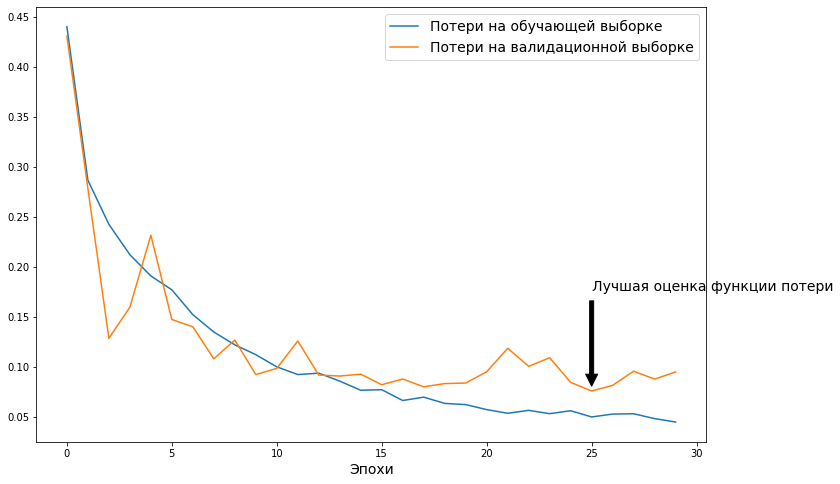

In [ ]:
plt.figure(figsize=(12, 8))
plt.annotate(
    'Лучшая оценка функции потери', 
    xy=(best_loss_index, best_loss_val), 
    xytext=(best_loss_index, best_loss_val+.1), 
    fontsize=14,
    arrowprops=dict(facecolor='black', shrink=0.05)
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Потери на обучающей выборке', 'Потери на валидационной выборке'], fontsize=14)
_ = plt.xlabel('Эпохи', fontsize=14)

С помощью callback-функции-чекпоинта, удалось сохранить лучшую модель, до того как началось переобучение

Сохранение лучшей модели

In [ ]:
from google.colab import files
nn2.save("best_model")
!zip -r /best_model.zip . -i /best_model/*
files.download("/best_model.zip")

INFO:tensorflow:Assets written to: best_model/assets
updating: best_model/keras_metadata.pb (deflated 87%)
updating: best_model/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip best_model.zip

Archive:  mape_57_r2_36_c_31.zip
   creating: mape_57_r2_36_c_31/
   creating: mape_57_r2_36_c_31/variables/
  inflating: mape_57_r2_36_c_31/variables/variables.index  
  inflating: mape_57_r2_36_c_31/variables/variables.data-00000-of-00001  
  inflating: mape_57_r2_36_c_31/keras_metadata.pb  
   creating: mape_57_r2_36_c_31/assets/
  inflating: mape_57_r2_36_c_31/saved_model.pb  


# Результаты


Лучшей моделью оказалась нейронная сеть со следующими значениями метрик:
- MAPE: 55%
- Собственная метрика: 32%

Эти значения не достаточно хорошие, но они лучше пороговых (MAPE: 91% и собственная метрика: 25%) <br>
<br>
Также есть предположение, медиана целевой метрики зависит от кластера (региона).